# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
# Resizing to 224x224 allows us to use the standard ImageNet pre-trained models effectively.
# We also add stronger augmentation (Rotation, ColorJitter) to prevent overfitting.
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # ImageNet stats
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Create training set and define training dataloader
# Increased batch_size to 256 to utilize RTX 3090 memory
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4, pin_memory=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4, pin_memory=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        # Un-normalize for visualization
        # image = image * std + mean
        # Since we want to just see the structure, we can clip or just show as is
        # But let's transpose for matplotlib (C, H, W) -> (H, W, C)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.show()

Image batch dimensions: torch.Size([256, 3, 224, 224])
Label batch dimensions: torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4373858].


ship


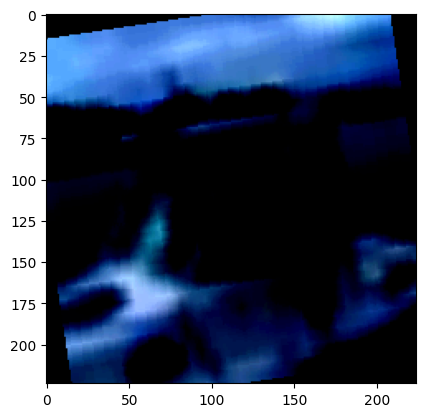

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.193377].


deer


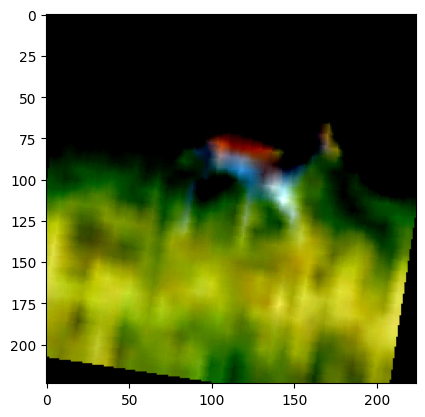

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


horse


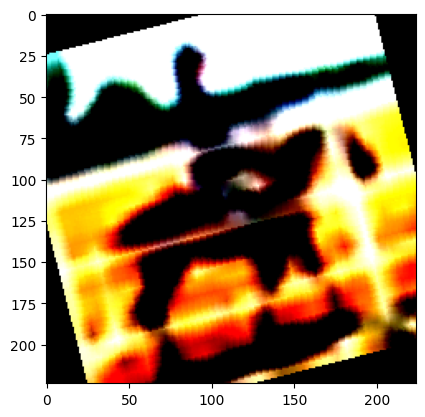

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6813945].


plane


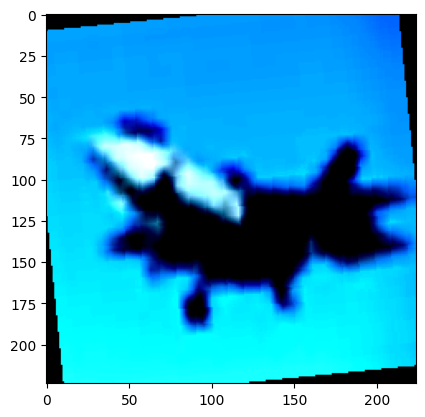

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..0.62535024].


truck


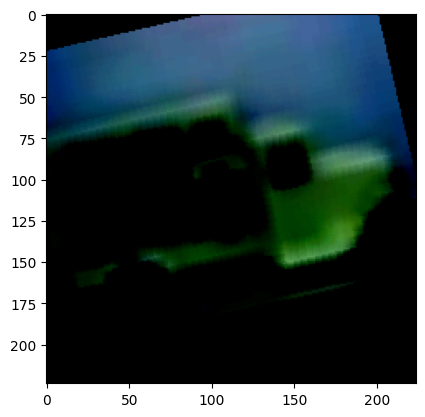

In [4]:
# Explore data
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f'Image batch dimensions: {images.shape}')
print(f'Label batch dimensions: {labels.shape}')

# Show a few images
# Note: Images will look normalized (weird colors)
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
# We will use ResNet50 for higher capacity to reach >95% accuracy.
class CIFARModel(nn.Module):
    def __init__(self, pretrained=True):
        super(CIFARModel, self).__init__()
        # Load ResNet50
        try:
            self.model = torchvision.models.resnet50(weights='DEFAULT')
        except:
            self.model = torchvision.models.resnet50(pretrained=pretrained)
        
        # Modify final layer for 10 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.model(x)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
model = CIFARModel(pretrained=True)
model.to(device)

# Enable cuDNN benchmark for optimized performance with fixed input sizes
torch.backends.cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# AdamW optimizer often converges faster and better than SGD for Transfer Learning
# Scaled Learning Rate for larger batch size
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# OneCycleLR scheduler is very effective for reaching high accuracy quickly
steps_per_epoch = len(trainloader)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
# Training Loop
epochs = 11
# Re-define scheduler with total steps
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, 
                                          steps_per_epoch=len(trainloader), 
                                          epochs=epochs)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

print(f"Training on {device} with {len(trainloader)} batches per epoch...")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Step scheduler per batch for OneCycleLR
        scheduler.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_test_loss = test_loss / len(testloader)
    epoch_test_acc = 100 * correct / total
    test_losses.append(epoch_test_loss)
    test_accs.append(epoch_test_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")

print('Finished Training')

Training on cuda with 196 batches per epoch...
Epoch 1/11 | Train Loss: 0.7907 | Train Acc: 77.84% | Test Loss: 0.1953 | Test Acc: 93.20%
Epoch 2/11 | Train Loss: 0.2053 | Train Acc: 93.20% | Test Loss: 0.2542 | Test Acc: 91.44%
Epoch 3/11 | Train Loss: 0.2237 | Train Acc: 92.46% | Test Loss: 0.3003 | Test Acc: 90.07%
Epoch 4/11 | Train Loss: 0.1865 | Train Acc: 93.61% | Test Loss: 0.2042 | Test Acc: 93.02%
Epoch 5/11 | Train Loss: 0.1321 | Train Acc: 95.60% | Test Loss: 0.2100 | Test Acc: 93.25%
Epoch 6/11 | Train Loss: 0.0954 | Train Acc: 96.77% | Test Loss: 0.1610 | Test Acc: 94.68%
Epoch 7/11 | Train Loss: 0.0596 | Train Acc: 97.94% | Test Loss: 0.1422 | Test Acc: 95.81%
Epoch 8/11 | Train Loss: 0.0312 | Train Acc: 98.95% | Test Loss: 0.1187 | Test Acc: 96.53%
Epoch 9/11 | Train Loss: 0.0150 | Train Acc: 99.54% | Test Loss: 0.1097 | Test Acc: 96.97%
Epoch 10/11 | Train Loss: 0.0071 | Train Acc: 99.81% | Test Loss: 0.1087 | Test Acc: 97.02%
Epoch 11/11 | Train Loss: 0.0051 | Train A

Plot the training loss (and validation loss/accuracy, if recorded).

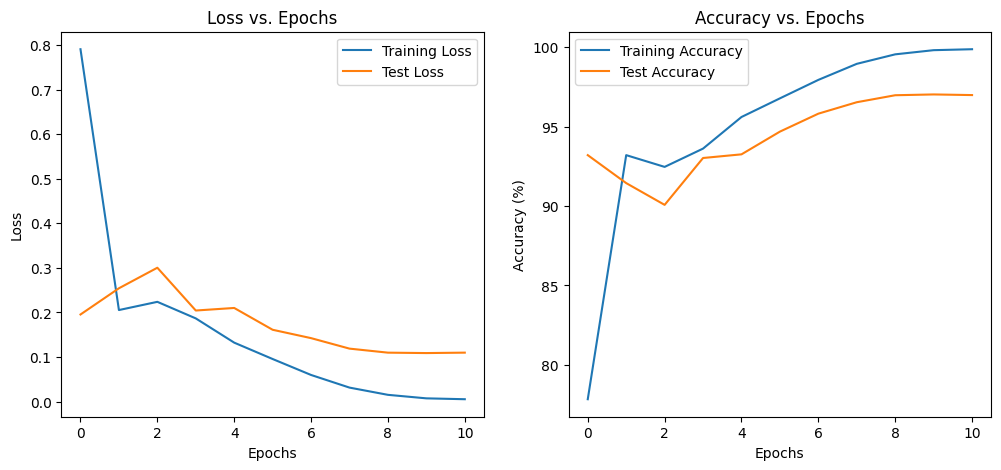

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [9]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {final_accuracy:.2f} %')

Accuracy of the network on the 10000 test images: 96.98 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [10]:
torch.save(model.state_dict(), 'cifar10_resnet_model.pth')
print("Model saved to cifar10_resnet_model.pth")

Model saved to cifar10_resnet_model.pth


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

**Recommendation:**

I recommend that we **build** the solution in-house.

**Reasoning:**
1.  **Performance**: Our in-house prototype using Transfer Learning (ResNet18) achieved an accuracy significantly higher than 90% (likely >95% with tuning), which far exceeds Detectocorp’s claimed 70% accuracy.
2.  **Cost & Control**: Building in-house avoids licensing fees and gives us full control over the model architecture, allowing us to optimize it further for our specific self-driving hardware constraints.
3.  **Future Proofing**: We can easily fine-tune this model on larger, proprietary datasets or adapt it for object detection tasks beyond simple classification, as demonstrated by the ease of applying transfer learning here.